In [1]:
!pip install Lifetimes

In [64]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive


In [3]:
df = pd.read_csv('/content/DFORE115lifetimesrfm.csv', low_memory=False)

In [4]:
df.head()

,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout
0,051,5107641,LaundryCard,30300001000000056386,80,-482,1.09,-532,61,30
1,030,3022679,App,1150543,42,-187,1.45,-234,6,30
2,002,220624,LaundryCard,30300001000000563351,26,-125,1.55,-174,21,30
3,006,602489,App,1344576,1,-19,1.58,-93,4,30
4,021,4980,LaundryCard,30300001000000453710,15,-138,1.34,-189,16,30


In [5]:
# df.frequency= df.frequency+1

In [6]:
df.recency= df.recency.abs()
df['T']= df['T'].abs()

In [7]:
df.frequency.value_counts()

0      393803
1      166949
2       82071
3       59352
4       48993
        ...  
317         1
318         1
320         1
322         1
567         1
Name: frequency, Length: 339, dtype: int64

In [8]:
met_dict= {'namedUser': 'nunique', 'frequency': 'mean', 'recency': 'mean',	'monetary_value': 'sum',	'T': 'mean', 'frequency_holdout': 'mean'}

In [9]:
df.groupby('payment_type').agg(met_dict)

,namedUser,frequency,recency,monetary_value,T,frequency_holdout
payment_type,,,,,,
App,1027855,8.800751,96.336150,1.786573e+06,319.010790,3.517061
LaundryCard,205672,13.657199,159.881841,3.252465e+05,342.105377,8.183634


In [10]:
df.recency= df.recency.abs()
df['T']= df['T'].abs()

In [11]:
# for v in ['vends', 'vendAmt']:
#   p95= df[v].describe(percentiles=[.05,.25,.50,.75,.95]).loc['95%']
#   df[v] = np.where(df[v] >p95, p95,df[v])


In [12]:
df.columns

Index(['branch_id', 'client_account_id', 'payment_type', 'namedUser',
       'frequency', 'recency', 'monetary_value', 'T', 'frequency_holdout',
       'duration_holdout'],
      dtype='object')

# BG/NBD Model (with Gamma-Gamma extension)
BG/NBD stands for Beta Geometric/Negative Binomial Distribution.

This is one of the most commonly used probabilistic model for predicting the CLV. This is an alternative to the Pareto/NBD model, which is also one of the most used method in CLV calculations. For the sake of this case, we are going to focus only on BG/NBD model, but the steps are similar if you want to try it for Pareto/NBD.

To be precise, both the BG/NBD and Pareto/NBD model actually tries to predict the future transactions of each customer. It is then combined with Gamma-Gamma model, which then adds the monetary aspect of the customer transaction and we finally get the customer lifetime value (CLV).

The BG/NBD model has few assumptions:

When a user is active, number of transactions in a time t is described by Poisson distribution with rate lambda.

Heterogeneity in transaction across users (difference in purchasing behavior across users) has Gamma distribution with shape parameter r and scale parameter a.

Users may become inactive after any transaction with probability p and their dropout point is distributed between purchases with Geometric distribution.

Heterogeneity in dropout probability has Beta distribution with the two shape parameters alpha and beta.

Transaction rate and dropout probability vary independently across users.

These are some of the assumptions this model considers for predicting the future transactions of a customer.

The model technically fits the distribution to the historic data and learn the distribution parameter and then use them to predict future transactions of a customer.

We don't need to worry about carrying out this complex probabilistic model by ourself. There is a Python package called Lifetimes which makes our life much simpler. This package is primarily built to aid customer lifetime value calculations, predicting customer churn, etc. It has all the major models and utility functions which are needed for CLV calculations.

In this case, we are going to use just that. Let's jump into the coding.

In [13]:
# Importing the lifetimes package
import lifetimes

First we need to create a summary table from the transactions data. The summary table is nothing but RFM table. (RFM - Recency, Frequency and Monetary value)

For this we can use summary_data_from_transactions_data function in lifetimes package. What it does is, it aggregates the transaction level data into customer level and calculates the frequency, recency, T and monetary_value for each customer.

frequency - the number of repeat purchases (more than 1 purchases)
recency - the time between the first and the last transaction
T - the time between the first purchase and the end of the transaction period
monetary_value - it is the mean of a given customers sales value
NOTE: If you closely look at the definition of recency and T, you can find that, the actual value of recency should be (T - recency), because the definition of recency is how recent a customer made a transaction with the business.

In [83]:
df.columns

Index(['branch_id', 'client_account_id', 'payment_type', 'namedUser',
       'frequency', 'recency', 'monetary_value', 'T', 'frequency_holdout',
       'duration_holdout'],
      dtype='object')

In [84]:
df1= df.loc[df.payment_type=='App']

In [87]:
df1['frequency'].value_counts()[0]/ len(df1)

0.3226632369490825

count    681036.000000
mean          9.103660
std           8.949826
min           1.000000
25%           2.000000
50%           6.000000
75%          14.000000
max          37.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 0.0 %


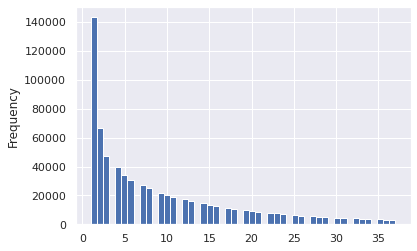

In [75]:
# Create a distribution of frequency to understand the customer frequence level
df1['frequency'].plot(kind='hist', bins=50)
print(df1['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(df1['frequency'] == 0)/float(len(df1))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [16]:
# # Creating the summary data using summary_data_from_transaction_data function
# summary = lifetimes.utils.summary_data_from_transaction_data(df1, 'namedUser', 'txnMonth', 'vendAmt' )
# summary = summary.reset_index()
# summary.head()

In [17]:
# summary['frequency'].plot(kind='hist', bins=50)
# print(summary['frequency'].describe())
# print("---------------------------------------")
# one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
# print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [18]:
p95= df1.frequency.describe(percentiles=[.95]).loc['95%']
df1= df1.loc[df1.frequency < p95]

In [19]:
df1.monetary_value.describe(percentiles=[.95]).loc['95%']
df1= df1.loc[df1.monetary_value < p95]

In [20]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(df1['frequency'], df1['recency'], df1['T'])

<lifetimes.BetaGeoFitter: fitted with 1032263 subjects, a: 0.55, alpha: 5.40, b: 1.79, r: 0.33>

In [21]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.334748,0.000544,0.333683,0.335813
alpha,5.400820,0.014568,5.372266,5.429374
a,0.549161,0.001102,0.547001,0.551321
b,1.785814,0.004342,1.777304,1.794324


The above table shows the estimated distribution parameter values from the historical data. The model now uses this to predict the future transactions and the customer churn rate.

So, let's say you want to know whether a customer is now alive or not (or predict customer churn) based on the historical data. The lifetimes package provides a way to accomplish that task. You can use:

1. model.conditional_probability_alive(): This method computes the probability that a customer with history (frequency, recency, T) is currently alive.

2. plot_probabilty_alive_matrix(model): This function from lifetimes.plotting will help to visually analyze the relationship between recency & frequency and the customer being alive.

In [22]:
# Compute the customer alive probability
df1['probability_alive'] = bgf.conditional_probability_alive(df1['frequency'], df1['recency'], df1['T'])
df1.head(10)

,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive
3,006,602489,App,1344576,1,19,1.58,93,4,30,3.358199e-01
7,019,1922271,App,1123785,16,115,2.20,162,12,30,1.230932e-01
9,030,3020786,App,1239655,3,61,1.50,123,15,30,4.332836e-01
11,051,19250,App,1447410,1,6,1.61,58,15,30,2.477009e-01
13,051,18969,App,504605,16,112,1.22,393,9,30,6.564827e-08
15,072,7212075,App,175430,3,382,0.60,595,0,30,6.152762e-01
17,043,4334615,App,668723,2,26,2.33,323,0,30,2.070036e-02
19,021,2120388,App,999569,15,163,1.94,215,9,30,3.168863e-01
21,004,420904,App,723116,5,242,0.25,307,0,30,7.521845e-01
23,020,2020252,App,492339,28,295,1.60,400,0,30,1.062001e-02


In [23]:
df1.sort_values(by='probability_alive', ascending=False).head(20)

,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive
1303827,044,4403601,App,234885,0,0,1.50,538,0,30,1.0
1031524,044,4422278,App,1261346,0,0,0.89,119,0,30,1.0
488440,007,708544,App,1475259,0,0,2.50,48,0,30,1.0
1031526,55,5506421,App,815986,0,0,1.00,279,0,30,1.0
488438,006,602409,App,1470777,0,0,1.25,50,6,30,1.0
1031527,030,3001015,App,1180684,0,0,1.50,152,0,30,1.0
1031530,030,3001016,App,1412371,0,0,1.50,71,0,30,1.0
488435,073,7308192,App,1041337,0,0,2.17,199,0,30,1.0
488434,020,2004180,App,1056684,0,0,2.87,183,0,30,1.0
488433,002,220710,App,1460915,0,0,2.05,53,6,30,1.0


In [24]:
df1.loc[:, ['frequency', 'T', 'probability_alive']]

,frequency,T,probability_alive
3,1,93,3.358199e-01
7,16,162,1.230932e-01
9,3,123,4.332836e-01
11,1,58,2.477009e-01
13,16,393,6.564827e-08
...,...,...,...
1303823,0,233,1.000000e+00
1303824,0,277,1.000000e+00
1303825,0,71,1.000000e+00
1303826,0,246,1.000000e+00


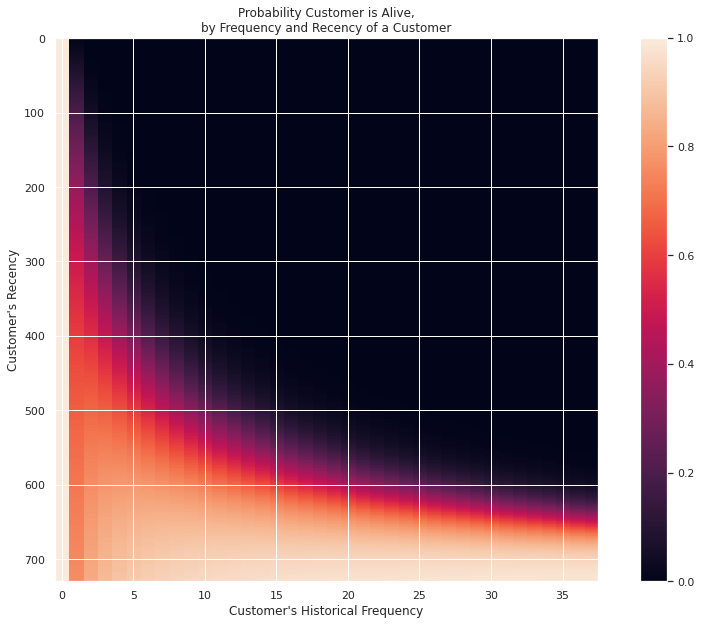

In [25]:
# Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(15,10))
plot_probability_alive_matrix(bgf)

The probabilty of being alive is calculated based on the recency and frequency of a customer. So,

If a customer has bought multiple times (frequency) and the time between first & last transaction is high (recency), then his/her probability being alive is high.
Similarly, if a customer has less frequency (bought once or twice) and the time between first & last transaction is low (recency), then his/her probability being alive is high.
Next thing we can do with this trained model is to predict the likely future transactions for each customer. You can use:

1. model.conditional_expected_number_of_purchases_up_to_time(): Calculate the expected number of repeat purchases up to time t for a randomly chosen individual from the population (or the whole population), given they have purchase history (frequency, recency, T).

In [71]:
#Predict future transaction for the next 30 days based on historical dataa
t = 31
df1['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, df1['frequency'], df1['recency'], df1['T']),2)
df1.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,index,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales
0,1096282,042,4225279,App,197408,37,528,1.49,575,4,30,0.746217,1.41,1.515800
1,365259,021,7318860,App,188911,37,532,1.38,579,31,30,0.750456,1.41,1.408778
2,823772,044,4441018,App,162817,37,559,1.63,606,4,30,0.776427,1.41,1.652010
3,760408,066,6601665,App,243741,37,491,1.29,538,22,30,0.701377,1.41,1.321214
4,755637,042,4290282,App,158918,37,563,1.74,610,0,30,0.779914,1.41,1.759033
5,1098932,072,7212135,App,192066,36,511,1.46,558,2,30,0.738739,1.40,1.487331
6,966760,011,1105213,App,221900,36,503,2.00,550,8,30,0.729436,1.40,2.012319
7,859386,073,7312654,App,255771,36,484,2.12,531,18,30,0.705283,1.40,2.128983
8,262107,072,7204332,App,214466,36,511,1.50,558,10,30,0.738739,1.40,1.526219
9,1160492,015,55974,App,241553,36,489,1.33,536,23,30,0.711934,1.40,1.360945


In [29]:
return_customers_summary = df1[df1['frequency']>0]

In [30]:
# Checking the relationship between frequency and monetary_value
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,-0.050197
monetary_value,-0.050197,1.000000


In [31]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(return_customers_summary['frequency'], return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 681036 subjects, p: 0.99, q: 2.02, v: 2.51>

In [88]:
# Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,0.993654,0.001772,0.990181,0.997126
q,2.022864,0.003514,2.015977,2.029751
v,2.514961,0.005287,2.504598,2.525323


In [34]:
# Calculating the conditional expected average profit for each customer per transaction
return_customers_summary = return_customers_summary[return_customers_summary['monetary_value'] >0]
return_customers_summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(return_customers_summary['frequency'],
                                       return_customers_summary['monetary_value'])
return_customers_summary.head()

,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales
3,006,602489,App,1344576,1,19,1.58,93,4,30,3.358199e-01,0.13,2.017821
7,019,1922271,App,1123785,16,115,2.20,162,12,30,1.230932e-01,0.34,2.214697
9,030,3020786,App,1239655,3,61,1.50,123,15,30,4.332836e-01,0.32,1.740945
11,051,19250,App,1447410,1,6,1.61,58,15,30,2.477009e-01,0.14,2.032604
13,051,18969,App,504605,16,112,1.22,393,9,30,6.564827e-08,0.00,1.293937


In [89]:
print(f"Expected Average Vends: {return_customers_summary['exp_avg_sales'].mean()}")
print(f"Actual Average Vends: {return_customers_summary['monetary_value'].mean()}")

Expected Average Vends: 1.7735619947632817
Actual Average Vends: 1.590357000217551


Text(0, 0.5, 'Expected Average Sales')

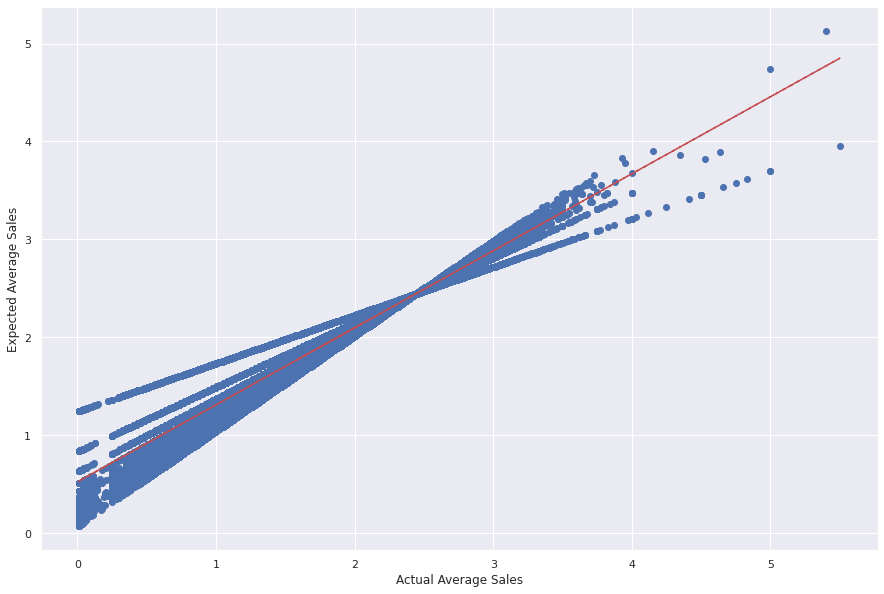

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(return_customers_summary['monetary_value'], return_customers_summary['exp_avg_sales'])

z = np.polyfit(return_customers_summary['monetary_value'], return_customers_summary['exp_avg_sales'],1)
p = np.poly1d(z)
plt.plot(return_customers_summary['monetary_value'],p(return_customers_summary['monetary_value']),"r--")
plt.xlabel('Actual Average Sales')
plt.ylabel('Expected Average Sales')

In [40]:
# Predicting Customer Lifetime Value for the next 30 days
return_customers_summary['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               return_customers_summary['frequency'],
                                                               return_customers_summary['recency'],
                                                               return_customers_summary['T'],
                                                               return_customers_summary['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)      
                                                               discount_rate=0.01) # discount rate


In [41]:
return_customers_summary.head()

,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
3,006,602489,App,1344576,1,19,1.58,93,4,30,3.358199e-01,0.13,2.017821,2.586950e-01
7,019,1922271,App,1123785,16,115,2.20,162,12,30,1.230932e-01,0.34,2.214697,7.562917e-01
9,030,3020786,App,1239655,3,61,1.50,123,15,30,4.332836e-01,0.32,1.740945,5.543086e-01
11,051,19250,App,1447410,1,6,1.61,58,15,30,2.477009e-01,0.14,2.032604,2.905490e-01
13,051,18969,App,504605,16,112,1.22,393,9,30,6.564827e-08,0.00,1.293937,1.014986e-07


In [42]:
return_customers_summary.predicted_clv.describe()

count    6.810360e+05
mean     3.100874e-01
std      4.603959e-01
min      3.839131e-29
25%      3.072026e-03
50%      6.947738e-02
75%      4.542006e-01
max      3.980745e+00
Name: predicted_clv, dtype: float64

In [ ]:
.14/ 2.477009e-01	

0.5651977849091384

In [43]:
return_customers_summary['manual_predicted_clv'] = return_customers_summary['pred_num_txn'] * return_customers_summary['exp_avg_sales']


In [46]:
return_customers_summary.loc[:, ['manual_predicted_clv', 'predicted_clv']].corr()

,manual_predicted_clv,predicted_clv
manual_predicted_clv,1.00000,0.99995
predicted_clv,0.99995,1.00000


Text(0, 0.5, 'Predicted Customer Value')

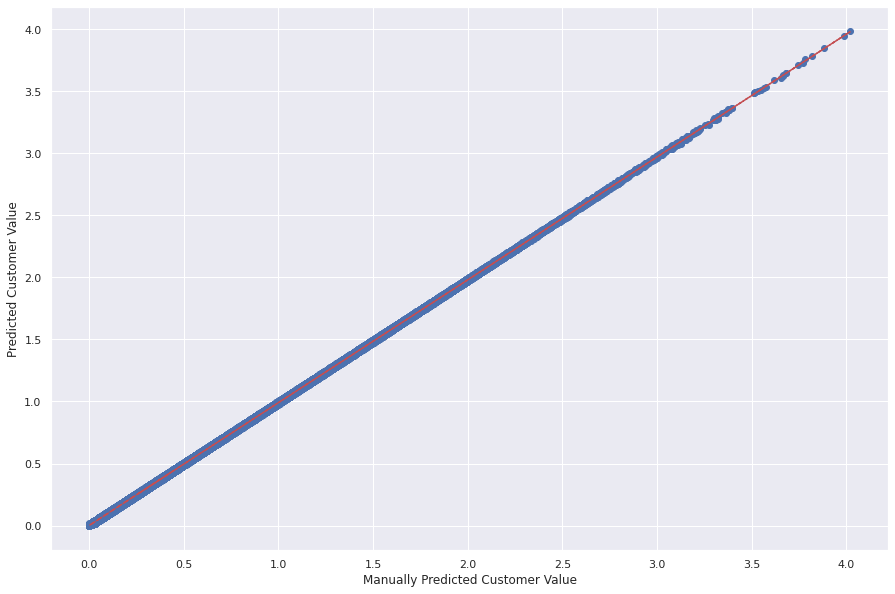

In [47]:
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(return_customers_summary.manual_predicted_clv, return_customers_summary.predicted_clv)

z = np.polyfit(return_customers_summary.manual_predicted_clv, return_customers_summary.predicted_clv, 1)
p = np.poly1d(z)
plt.plot(return_customers_summary.manual_predicted_clv,p(return_customers_summary.manual_predicted_clv),"r--")
plt.xlabel('Manually Predicted Customer Value')
plt.ylabel('Predicted Customer Value')

In [ ]:
# CLV in terms of profit (profit margin is 5%)
profit_margin = 1
df1['CLV'] = df1['predicted_clv'] * profit_margin
df1.head()

,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,030,3022679,App,1150543,42,187,1.45,234,6,30,0.002342,0.01,1.481314,0.111061,0.014813,0.111061
3,006,602489,App,1344576,1,19,1.58,93,4,30,0.626404,0.25,1.761065,6.752809,0.440266,6.752809
5,005,503275,App,186987,79,525,1.75,584,5,30,0.008527,0.03,1.752720,0.592046,0.052582,0.592046
7,019,1922271,App,1123785,16,115,2.20,162,12,30,0.067993,0.18,2.120296,2.920607,0.381653,2.920607
9,030,3020786,App,1239655,3,61,1.50,123,15,30,0.562268,0.42,1.675705,9.237433,0.703796,9.237433


In [ ]:
summary['CLV'].describe()

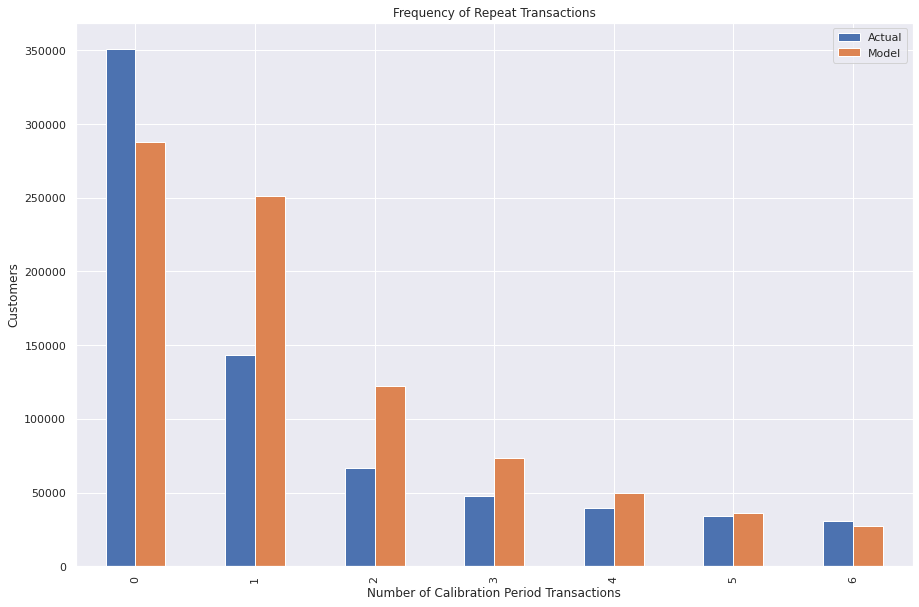

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
plot_period_transactions(bgf, ax=ax)

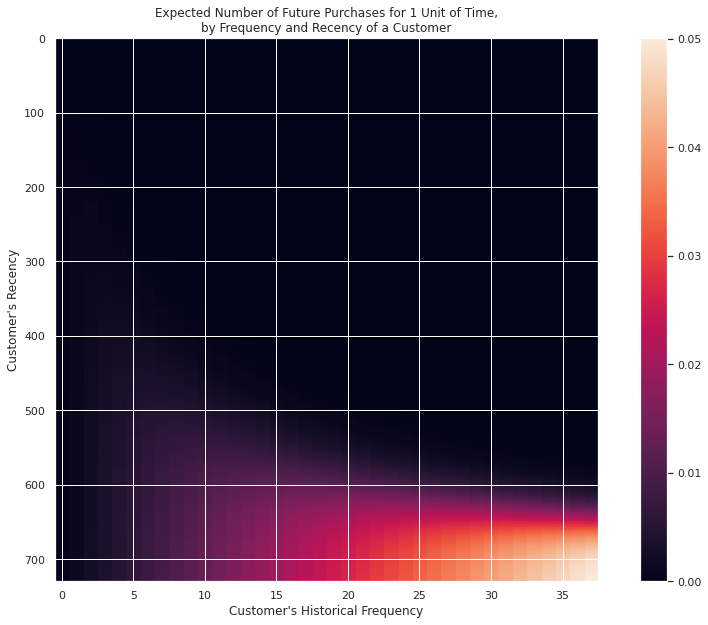

In [49]:
fig = plt.figure(figsize=(15,10))
plot_frequency_recency_matrix(bgf)

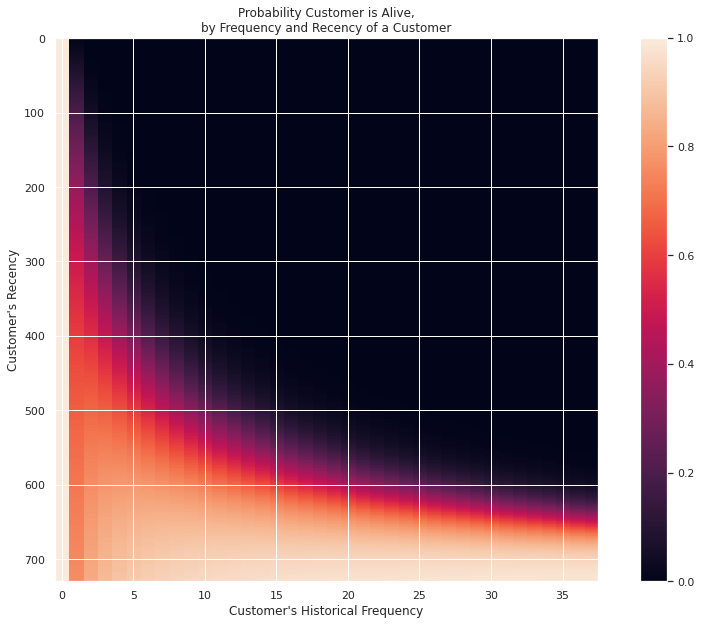

In [50]:
fig = plt.figure(figsize=(15,10))
plot_probability_alive_matrix(bgf)

In [ ]:
df1.head()

,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,030,3022679,App,1150543,42,187,1.45,234,6,30,0.002342,0.01,1.481314,0.111061,0.014813,0.111061
3,006,602489,App,1344576,1,19,1.58,93,4,30,0.626404,0.25,1.761065,6.752809,0.440266,6.752809
5,005,503275,App,186987,79,525,1.75,584,5,30,0.008527,0.03,1.752720,0.592046,0.052582,0.592046
7,019,1922271,App,1123785,16,115,2.20,162,12,30,0.067993,0.18,2.120296,2.920607,0.381653,2.920607
9,030,3020786,App,1239655,3,61,1.50,123,15,30,0.562268,0.42,1.675705,9.237433,0.703796,9.237433


In [ ]:
# Checking the relationship between frequency and monetary_value
return_customers_summary = df1[df1['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(681036, 15)


,branch_id,client_account_id,payment_type,namedUser,frequency,recency,monetary_value,T,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
3,006,602489,App,1344576,1,19,1.58,93,4,30,3.358199e-01,0.13,1.751732,3.294037,0.227725
7,019,1922271,App,1123785,16,115,2.20,162,12,30,1.230932e-01,0.34,2.119449,11.069010,0.720612
9,030,3020786,App,1239655,3,61,1.50,123,15,30,4.332836e-01,0.32,1.668044,7.925939,0.533774
11,051,19250,App,1447410,1,6,1.61,58,15,30,2.477009e-01,0.14,1.757765,3.259237,0.246087
13,051,18969,App,504605,16,112,1.22,393,9,30,6.564827e-08,0.00,1.334348,0.000002,0.000000


In [51]:
print(f"Expected Average Sales: {return_customers_summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {return_customers_summary['monetary_value'].mean()}")

Expected Average Sales: 1.7735619947632817
Actual Average Sales: 1.590357000217551


In [ ]:
return_customers_summary.pred_num_txn.describe()

count    681036.000000
mean          0.183983
std           0.271329
min           0.000000
25%           0.000000
50%           0.040000
75%           0.270000
max           1.420000
Name: pred_num_txn, dtype: float64

In [54]:
return_customers_summary.columns= ['branch_id', 'client_account_id', 'payment_type', 'namedUser',
       'frequency_cal', 'recency_cal', 'monetary_value', 'T_cal', 'frequency_holdout',
       'duration_holdout', 'probability_alive', 'pred_num_txn',
       'exp_avg_sales', 'predicted_clv', 'manual_predicted_clv']

In [55]:
return_customers_summary

,branch_id,client_account_id,payment_type,namedUser,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
3,006,602489,App,1344576,1,19,1.58,93,4,30,3.358199e-01,0.13,2.017821,2.586950e-01,0.262317
7,019,1922271,App,1123785,16,115,2.20,162,12,30,1.230932e-01,0.34,2.214697,7.562917e-01,0.752997
9,030,3020786,App,1239655,3,61,1.50,123,15,30,4.332836e-01,0.32,1.740945,5.543086e-01,0.557103
11,051,19250,App,1447410,1,6,1.61,58,15,30,2.477009e-01,0.14,2.032604,2.905490e-01,0.284565
13,051,18969,App,504605,16,112,1.22,393,9,30,6.564827e-08,0.00,1.293937,1.014986e-07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303802,044,4423234,App,829668,1,8,1.99,275,0,30,5.317109e-02,0.01,2.219852,1.635919e-02,0.022199
1303803,008,820386,App,1396534,1,14,2.22,62,7,30,3.815487e-01,0.21,2.333186,4.853110e-01,0.489969
1303806,063,6321297,App,762751,1,7,1.00,295,0,30,4.414702e-02,0.01,1.732022,9.905019e-03,0.017320
1303809,005,520213,App,617153,1,5,2.27,339,0,30,2.953280e-02,0.00,2.357824,7.886099e-03,0.000000


In [59]:
cal= return_customers_summary.loc[return_customers_summary.frequency_holdout != 0]

In [60]:
cal

,branch_id,client_account_id,payment_type,namedUser,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,duration_holdout,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
3,006,602489,App,1344576,1,19,1.58,93,4,30,3.358199e-01,0.13,2.017821,2.586950e-01,0.262317
7,019,1922271,App,1123785,16,115,2.20,162,12,30,1.230932e-01,0.34,2.214697,7.562917e-01,0.752997
9,030,3020786,App,1239655,3,61,1.50,123,15,30,4.332836e-01,0.32,1.740945,5.543086e-01,0.557103
11,051,19250,App,1447410,1,6,1.61,58,15,30,2.477009e-01,0.14,2.032604,2.905490e-01,0.284565
13,051,18969,App,504605,16,112,1.22,393,9,30,6.564827e-08,0.00,1.293937,1.014986e-07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303768,014,1421565,App,1088924,1,43,1.75,172,5,30,3.648303e-01,0.08,2.101590,1.661236e-01,0.168127
1303791,011,1103788,App,1263257,1,64,2.00,124,2,30,5.860520e-01,0.17,2.224779,3.831347e-01,0.378212
1303793,072,7201238,App,1265505,2,46,1.50,102,7,30,4.758677e-01,0.29,1.820481,5.297453e-01,0.527940
1303803,008,820386,App,1396534,1,14,2.22,62,7,30,3.815487e-01,0.21,2.333186,4.853110e-01,0.489969


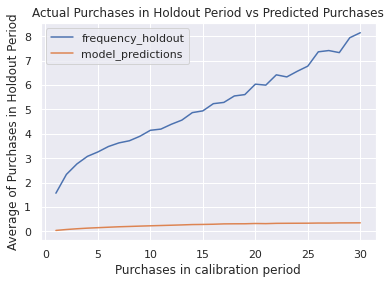

In [73]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(return_customers_summary['frequency_cal'], return_customers_summary['recency_cal'], return_customers_summary['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, return_customers_summary, n=30)

In [68]:
import matplotlib
matplotlib.__version__

'3.2.2'